## Process models

ProcessModel objects allow us to write code for multiple related configurations with ease. It streamlines system creation and provides an easy handle to access objects within a model configuration (e.g., chemicals, streams, units, systems). ProcessModel is an abstract class which has missing (or "abstract") attributes and methods. The user must define a `Scenario` dataclass which determines all inputs to the process model. Additionally, the user must define the `as_scenario`, `create_thermo`, `create_system`, and `create_model` methods for the process model to initialize its key components. 

It may help to look at how ProcessModel objects are created (approximately):
    
```python
def __new__(cls, simulate=None, scenario=None, **kwargs):
    if scenario is None:
        self.scenario = cls.Scenario(**kwargs)
    else:
        # The Scenario object can be initialized through the `as_scenario` class method.
        self.scenario = cls.as_scenario(scenario)
    
    # No need to recreate a process model for repeated scenarios.
    if scenario in cls.cache: return cls.cache[scenario]
    self = super().__new__()
    
    # The thermodynamic property package is given by the `create_thermo` method.
    self.load_thermo(self.create_thermo())
    
    # If no system is returned by the `create_system` method, a new system is created from flowsheet units.
    self.flowsheet = bst.Flowsheet()
    system = self.create_system()
    if system is None: system = self.flowsheet.create_system()
    
    # This saves the system as self.system and all units/streams as attributes by ID.
    # For example, Stream('feedstock') will be stored as self.feestock.
    self.load_system(system) 
    
    # A Model object is loaded from the `create_model` method.
    # The model will be stored as self.model and all parameters and metrics as attributes by function name.
    # For example: 
    #
    # @model.metric
    # def MSP(): return self.tea.solve_price(self.product)
    #
    # ^ This becomes self.MSP.
    self.load_model(self.create_model())
    
    if simulate: self.system.simulate()
    self.cache[scenario] = self
    return self

```
    
In this chapter, we will create a ProcessModel object to facilitate the economic analysis of cellulosic ethanol production for two alternative biorefinery configurations: one processing cornstover with dilute acid pretreatment [1] and another processing switchgrass with AFEX pretreatment [2]. For simplicity, assumptions on fermentation performance in the switchgrass biorefinery are the same as in the cornstover biorefinery.

In [1]:
from biorefineries import cellulosic
from biorefineries.ethanol import create_ethanol_purification_system
from biorefineries.tea import create_cellulosic_ethanol_tea
import biosteam as bst
bst.nbtutorial()

class CellulosicEthanolBiorefinery(bst.ProcessModel):
    # The 'Scenario' class defines arguments to the process model.
    # It works very similar to a python dataclass: https://docs.python.org/3/library/dataclasses.html
    class Scenario:
        # To define an argument, you must include the type, but the default is optional.
        # You can also add metadata by tagging along a string that starts with #.
        feedstock: str = 'cornstover', '# dry at 20% moisture content'
        pretreatment: str = 'dilute acid'
    
    @classmethod
    def as_scenario(cls, scenario):
        """
        This method allows the process model to interpret objects 
        (e.g., strings, numbers) as a Scenario.
        """
        # Interpret strings in the form of '{feedstock}/{pretreatment}' as a scenario.
        feedstock, pretreatment = scenario.split('/')
        return cls.Scenario(feedstock, pretreatment)
    
    def create_thermo(self):
        """
        This method should return a chemicals or thermo object.
        BioSTEAM will automatically set it as the thermodynmic property package.
        """
        return cellulosic.create_cellulosic_ethanol_chemicals()
    
    def create_system(self):
        """
        This method should create unit operations and connect them.
        It can return a system object, optionally. Otherwise, BioSTEAM will 
        take care of creating the system from these units and saves 
        it as the `self.system` attribute.
        All streams and unit operations are also saved as attributes by their ID.
        """
        cellulosic.load_process_settings()
        scenario = self.scenario # The input paremters to the process model are saved here.
        if self.scenario.feedstock == 'cornstover':
            feedstock = bst.Stream(
                ID='feedstock',
                price=0.0516,
                total_flow=104229.16,
                units='kg/hr',
                Water=0.20215,
                Sucrose=0.00623,
                Extract=0.11846,
                Acetate=0.01464,
                Ash=0.03986,
                Lignin=0.12744,
                Protein=0.02507,
                Glucan=0.28302,
                Xylan=0.15788,
                Arabinan=0.01925,
                Mannan=0.00485,
                Galactan=0.00116,
            )
        elif self.scenario.feedstock == 'switchgrass':
            feedstock = bst.Stream(
                ID='feedstock',
                total_flow=104229.16,
                price=0.08,
                units='kg/hr',
                Arabinan=0.02789,
                Galactan=0.01044,
                Glucan=0.2717,
                Xylan=0.21215,
                Mannan=0.00594,
                Lignin=0.17112,
                Ash=0.01619,
                Extract=0.0756,
                Acetate=0.00897,
                Water=0.2,
            )
        else:
            raise ValueError('invalid feedstock')
        
        ethanol = bst.Stream(ID='ethanol', price=0.5)
        U101 = cellulosic.units.FeedStockHandling('U101', feedstock)
        U101.cost_items['System'].cost = 0.
        
        if scenario.pretreatment == 'dilute acid':
            create_pretreatment_sys = cellulosic.create_dilute_acid_pretreatment_system
        elif scenario.pretreatment == 'AFEX':
            create_pretreatment_sys = cellulosic.create_ammonia_fiber_expansion_pretreatment_system
        else:
            raise ValueError('invalid pretreatment')
            
        pretreatment_sys = create_pretreatment_sys(
            ins=U101-0, area=200, mockup=True,
        )
        fermentation_sys = cellulosic.create_cellulosic_fermentation_system(
            ins=pretreatment_sys.get_outlet('pretreated_biomass'), area=300, mockup=True,
            # Valid arguments include:
            # Integrated Bioprocess (IB)
            # Simultaneous Saccharification and Co-Fermentation (SSCF)
            # Saccharification and Co-Fermentation (SCF)
            kind='IB',
        )
        ethanol_purification_sys = create_ethanol_purification_system(
            ins=fermentation_sys.get_outlet('beer'),
            outs=[ethanol], area=400, mockup=True,
        )
        ethanol, stillage, stripper_bottoms_product = ethanol_purification_sys.outs
        water = bst.Stream(Water=1, T=47+273.15, P=3.9*101325, units='kg/hr')
        S401 = bst.PressureFilter(400, (stillage, water))
        bst.create_all_facilities(
            # Certain facilities like the Fire Water Tank (in case there is a fire)
            # is sized based on feedstock flow rate
            feedstock,
            recycle_process_water_streams=[stripper_bottoms_product],
            HXN=False, # No heat exchanger network,
            area=600,
        )
    
    def create_model(self):
        """
        This method should return a model object. The model will be saved as a self.model attribute. 
        All pareameters and metrics of the model object will also be saved as attributes by their 
        function names.
        """
        system = self.system # BioSTEAM automaticaly creates the system and saves it as self.system
        self.tea = tea = create_cellulosic_ethanol_tea(system)
        model = bst.Model(system)
        price = self.feedstock.price * 1000 # USD / MT
        processing_capacity = self.feedstock.F_mass * tea.operating_hours / 1e6 # 10^3 MT / y
        
        @model.parameter(
            element='feedstock', units='USD/kg', # Metadata for pretty tables/plots
            baseline=price, # Baseline price
            bounds=(price * 0.9, price * 1.1) # Min/max price
        )
        def set_feedstock_price(feedstock_price):
            self.feedstock.price = feedstock_price / 1000

        @model.parameter(
            element='feedstock', units='10^3 MT/y',
            baseline=processing_capacity,
            bounds=(processing_capacity * 0.9, processing_capacity * 1.1)
        )
        def set_processing_capacity(processing_capacity):
            self.feedstock.F_mass = 1e6 * processing_capacity /  tea.operating_hours 

        @model.metric(units='USD/gal')
        def MESP():
            return tea.solve_price(self.ethanol) * 2.98668849 # USD/kg to USD/gal
        
        return model


Let's create the cellulosic ethanol biorefinery and explore the process model attributes.

In [2]:
# Create the process model without simulating the system
cellulosic_br = CellulosicEthanolBiorefinery(scenario='cornstover/dilute acid', simulate=False)
cellulosic_br

CellulosicEthanolBiorefinery(
    feedstock='cornstover', # dry at 20% moisture content
    pretreatment='dilute acid',
)


In [4]:
# Simulate and look at the diagram
cellulosic_br.system.simulate()
cellulosic_br.system.diagram('cluster')

In [5]:
# Access any unit operation or stream in the system
cellulosic_br.R301.results(basis='SI')

Saccharification and co fermentation              Units      R301
Electricity         Power                            kW   1.3e+03
                    Cost                         USD/hr      74.1
Chilled water       Duty                          kJ/hr -4.27e+07
                    Flow                        kmol/hr  2.86e+04
                    Cost                         USD/hr         0
Design              Flow rate                      m³/s   0.00917
                    Reactor volume                   m³     4e+03
                    Batch time                                109
                    Loading time                             9.09
                    Batch duty                 kg·m²/s³ -6.49e+06
                    Reactor duty               kg·m²/s³ -5.36e+06
Purchase cost       Reactors (x12)                  USD  1.05e+07
                    Agitators (x12)                 USD  6.52e+05
                    Fermentor batch cooler          USD  9.45e+04
                    Heat exchangers (x12)           USD  2.73e+05
                    Recirculation pumps (x12)       USD  2.89e+05
Total purchase cost                                 USD  1.18e+07
Utility cost                                     USD/hr      74.1

In [6]:
# Access the model
cellulosic_br.model

Model:
parameters: Feedstock - Feedstock price [USD/kg]
            Feedstock - Processing capacity [10^3 MT/y]
metrics: MESP [USD/gal]


In [7]:
cellulosic_br.MESP

<Metric: MESP (USD/gal)>

In [8]:
# Access the model
cellulosic_br.model

Model:
parameters: Feedstock - Feedstock price [USD/kg]
            Feedstock - Processing capacity [10^3 MT/y]
metrics: MESP [USD/gal]


In [9]:
# Access model parameters and metrics
cellulosic_br.set_feedstock_price(0.06)
cellulosic_br.MESP()

1.2712718361058306

Note how all streams, units, systems, parameters and metrics can be easily accessed. Let's now use the process model to conduct a simple uncertainty analysis on the impact of feedstock price and flow rate on the minimum ethanol selling price for each configuration:

Text(0, 0.5, 'MESP [USD/gal]')

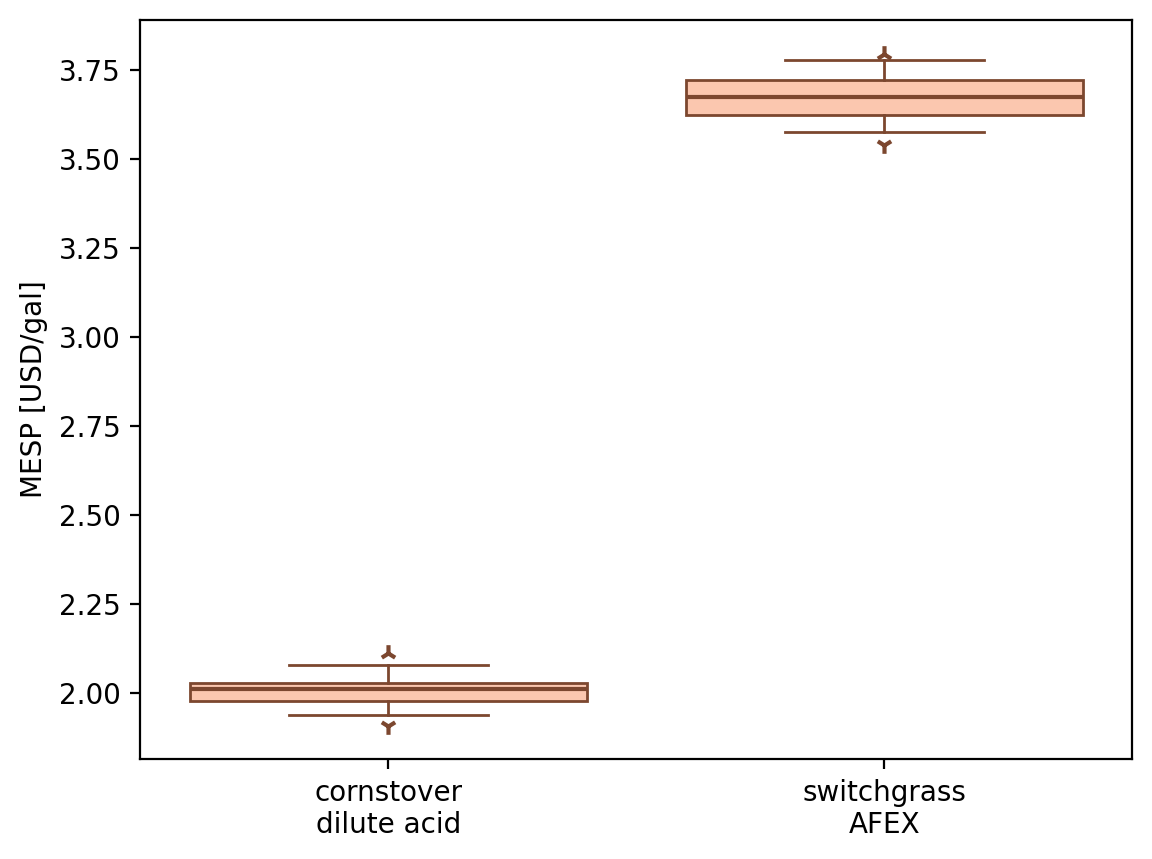

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from biosteam.plots import plot_montecarlo

scenarios = ['cornstover/dilute acid', 'switchgrass/AFEX']
biorefineries = []
data = []
for scenario in scenarios:
    br = CellulosicEthanolBiorefinery(scenario=scenario, simulate=False)
    samples = br.model.sample(50, 'L')
    br.model.load_samples(samples, sort=True)
    br.model.evaluate()
    biorefineries.append(br)
    data.append(br.model.table[br.MESP.index])

dct = plot_montecarlo(data=np.array(data), xmarks=[i.replace('/', '\n') for i in scenarios])
plt.ylabel(br.MESP.describe())

Using the ProcessModel objects, we were quickly able to define the biorefinery models and configurations and conduct uncertainty and sensitivity analyses. Biorefineries in the [Bioindustrial-Park](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park) repository leverage ProcessModel objects in this way too.

While this dumbed-down uncertainty analysis suggests that one configuration is much more economically viable than the other,  the assumptions behind the analysis are arbitrary and a more rigorous uncertainty analyses would base all assumptions on expert knowledge. 

### References

<a id='References'></a>

1. Humbird, D. et al. Process design and economics for biochemical conversion of lignocellulosic biomass to ethanol: Dilute-acid pretreatment and enzymatic hydrolysis of corn stover. http://www.nrel.gov/docs/fy11osti/47764.pdf (2011).

2. Serate, J. et al. Controlling microbial contamination during hydrolysis of AFEX-pretreated corn stover and switchgrass: effects on hydrolysate composition, microbial response and fermentation. Biotechnol Biofuels 8, 180 (2015).
